In [1]:
import os

# This checks the input directory
for dirname, _, filenames in os.walk('/kaggle/input'):
    print(f"Directory: {dirname}")
    if len(filenames) > 0:
        print(f"Found {len(filenames)} files. First one: {filenames[0]}")
        break

Directory: /kaggle/input
Directory: /kaggle/input/kaggle-bms-data
Found 110 files. First one: Cell 2 Measurements - Twelfth Photovoltaic Load Clear - GC discharge.csv


In [2]:
import pandas as pd
import os
import re
from pathlib import Path
import numpy as np
from datetime import datetime

class BMSDataProcessor:
    """Battery Management System Data Processing Pipeline"""
    
    def __init__(self, data_directory):
        self.data_directory = Path(data_directory)
        self.master_df = None
        # Pattern to extract Cell ID and Test Condition
        self.file_pattern = r'Cell\s+(\d+)\s+Measurements\s+-\s+(.+)\.csv'
        
    def extract_metadata_from_filename(self, filename):
        match = re.search(self.file_pattern, filename, re.IGNORECASE)
        if match:
            cell_id = int(match.group(1))
            test_condition = match.group(2).strip()
            return cell_id, test_condition
        return None, None
    
    def clean_numeric_column(self, df, column_name):
        if column_name not in df.columns:
            return None
        
        # Handle comma decimal separators (European format)
        cleaned = df[column_name].astype(str).str.replace(',', '.')
        # Remove any whitespace
        cleaned = cleaned.str.strip()
        # Convert to numeric, coercing errors to NaN
        return pd.to_numeric(cleaned, errors='coerce')
    
    def normalize_column_names(self, df):
        """
        Normalize column names using regex to create consistent column names across all files
        """
        # Create a mapping dictionary for column renaming
        column_mapping = {}
        
        for col in df.columns:
            # Skip if already processed
            if col in ['Cell_ID', 'Test_Condition', 'Timestamp']:
                continue
            
            # Drop Unnamed columns
            if col.startswith('Unnamed'):
                column_mapping[col] = None  # Mark for deletion
                continue
            
            # Normalize column name
            normalized = col
            
            # Voltage (V) - matches V1 (V), V2 (V), Vn (V), etc.
            if re.search(r'V\d*\s*\(V\)', col, re.IGNORECASE):
                normalized = 'Voltage_V'
            
            # Voltage (mV) - matches V1 (mV), V2 (mV), etc.
            elif re.search(r'V\d*\s*\(mV\)', col, re.IGNORECASE):
                normalized = 'Voltage_mV'
            
            # Temperature - matches T1 (ºC), T2 (°C), Tn (ºC), T1 (C), etc.
            elif re.search(r'T\d*\s*\([^\)]*C\)', col, re.IGNORECASE):
                normalized = 'Temperature_C'
            
            # Current - matches I (A), I1 (A), Current (A), etc.
            elif re.search(r'(I\d*\s*\(A\)|Current)', col, re.IGNORECASE):
                normalized = 'Current_A'
            
            # SOC - matches %SOC, % SOC, %SoC, % SoC, SOC, SoC
            elif re.search(r'%?\s*So?C', col, re.IGNORECASE):
                normalized = 'SOC_Percent'
            
            # Capacity - matches Ah, (Ah), Capacity Ah, etc.
            elif re.search(r'(Ah|\(Ah\)|Capacity)', col, re.IGNORECASE):
                normalized = 'Capacity_Ah'
            
            # Only add to mapping if name changed
            if normalized != col:
                column_mapping[col] = normalized
        
        # Apply renaming
        df_renamed = df.copy()
        
        # First, drop all Unnamed columns
        cols_to_drop = [col for col, new_name in column_mapping.items() if new_name is None]
        if cols_to_drop:
            df_renamed = df_renamed.drop(columns=cols_to_drop)
        
        # Then rename the rest
        rename_dict = {col: new_name for col, new_name in column_mapping.items() if new_name is not None}
        if rename_dict:
            df_renamed = df_renamed.rename(columns=rename_dict)
        
        return df_renamed
    
    def process_single_file(self, filepath):
        try:
            # Extract metadata from filename
            cell_id, test_condition = self.extract_metadata_from_filename(filepath.name)
            
            if cell_id is None:
                # Fallback: if filename pattern fails, try simpler check or skip
                if "Cell 1" in filepath.name: cell_id = 1
                elif "Cell 2" in filepath.name: cell_id = 2
                elif "Cell 3" in filepath.name: cell_id = 3
                elif "Cell 4" in filepath.name: cell_id = 4
                elif "Cell 5" in filepath.name: cell_id = 5
                elif "Cell 6" in filepath.name: cell_id = 6
                test_condition = filepath.stem 
            
            # Read CSV with semicolon delimiter and Latin-1 encoding
            df = pd.read_csv(filepath, sep=';', encoding='latin1', 
                           on_bad_lines='warn', engine='python')
            
            # Normalize column names using regex
            df = self.normalize_column_names(df)
            
            # Add metadata columns
            df['Cell_ID'] = cell_id
            df['Test_Condition'] = test_condition
            
            # Convert timestamp to datetime with European format (day first)
            if 'Timestamp' in df.columns:
                df['Timestamp'] = pd.to_datetime(df['Timestamp'], errors='coerce', dayfirst=True)
            
            # Clean numeric columns - now using standardized names
            numeric_columns = ['Voltage_V', 'Voltage_mV', 'Temperature_C', 'Current_A', 'SOC_Percent', 'Capacity_Ah']
            
            for col in numeric_columns:
                if col in df.columns:
                    df[col] = self.clean_numeric_column(df, col)
            
            # Remove any completely empty rows
            df = df.dropna(how='all')
            
            # Remove any completely empty columns
            df = df.dropna(axis=1, how='all')
            
            print(f"✓ Processed {filepath.name[:50]}... | Cell {cell_id} | Columns: {len(df.columns)}")
            return df
            
        except Exception as e:
            print(f"❌ Error processing {filepath.name}: {str(e)}")
            import traceback
            traceback.print_exc()
            return None

    # --- [NEW METHOD START] ---
    def calculate_soh(self):
        """Calculates State of Health (SOH) based on capacity fade."""
        if self.master_df is None or 'Capacity_Ah' not in self.master_df.columns:
            print("⚠️ Cannot calculate SOH: 'Capacity_Ah' column missing.")
            return

        print(f"\n{'='*70}")
        print("❤️ Calculating State of Health (SOH)...")
        
        # 1. Calculate Max Capacity for each Cycle (Test Condition)
        # We assume each 'Test_Condition' represents a full discharge/charge cycle event
        cycle_caps = self.master_df.groupby(['Cell_ID', 'Test_Condition'])['Capacity_Ah'].max().reset_index()
        cycle_caps.rename(columns={'Capacity_Ah': 'Cycle_Max_Cap'}, inplace=True)
        
        # 2. Determine Nominal Capacity (Baseline)
        # We take the highest capacity ever recorded in the dataset as the "100% Health" baseline.
        if cycle_caps.empty:
             print("⚠️ No cycle data found to calculate SOH.")
             return

        nominal_capacity = cycle_caps['Cycle_Max_Cap'].max()
        print(f"  > Nominal Capacity (New Battery Baseline): {nominal_capacity:.4f} Ah")
        
        # 3. Compute SOH %
        # Formula: (Current_Cycle_Capacity / Nominal_Capacity) * 100
        cycle_caps['SOH'] = (cycle_caps['Cycle_Max_Cap'] / nominal_capacity) * 100
        
        # 4. Merge SOH back to Master DF
        # This assigns the calculated SOH to every single row (timestamp) in that cycle
        self.master_df = pd.merge(self.master_df, 
                                  cycle_caps[['Cell_ID', 'Test_Condition', 'SOH']], 
                                  on=['Cell_ID', 'Test_Condition'], 
                                  how='left')
        
        print(f"  > SOH Calculated. Range: {self.master_df['SOH'].min():.2f}% - {self.master_df['SOH'].max():.2f}%")
    # --- [NEW METHOD END] ---
    
    def batch_load_and_merge(self):
        print(f"\n{'='*70}")
        print(f"BMS Data Processing Pipeline")
        print(f"{'='*70}\n")
        print(f"📂 Scanning directory: {self.data_directory}")
        print(f"📂 Directory exists: {self.data_directory.exists()}")
        print(f"📂 Is directory: {self.data_directory.is_dir()}")
        
        # Find all CSV files
        csv_files = list(self.data_directory.glob('*.csv'))
        print(f"🔍 Glob pattern '*.csv' found: {len(csv_files)} files")
        
        if not csv_files:
            print("⚠️  No CSV files found in directory!")
            return None
        
        print(f"📄 Found {len(csv_files)} CSV file(s)\n")
        
        # Process each file
        dataframes = []
        for filepath in csv_files:
            df = self.process_single_file(filepath)
            if df is not None:
                dataframes.append(df)
        
        if not dataframes:
            print("\n❌ No files were successfully processed!")
            return None
        
        # Merge all dataframes
        print(f"\n{'='*70}")
        print("🔗 Merging all dataframes...")
        self.master_df = pd.concat(dataframes, ignore_index=True)
        
        # Sort by Cell_ID and Timestamp
        if 'Timestamp' in self.master_df.columns:
            self.master_df = self.master_df.sort_values(['Cell_ID', 'Timestamp'])
        else:
            self.master_df = self.master_df.sort_values('Cell_ID')
        
        self.master_df = self.master_df.reset_index(drop=True)

        # --- [CHANGE: CALL SOH CALCULATION] ---
        self.calculate_soh()
        
        return self.master_df
    
    def generate_summary(self):
        if self.master_df is None: 
            print("No data to summarize!")
            return
        
        print(f"{'='*70}")
        print("📊 MASTER DATAFRAME SUMMARY")
        print(f"{'='*70}\n")
        
        print(f"Total Rows: {len(self.master_df):,}")
        print(f"Total Columns: {len(self.master_df.columns)}")
        print(f"Memory Usage: {self.master_df.memory_usage(deep=True).sum() / 1024**2:.2f} MB\n")
        
        print("Columns:")
        for col in self.master_df.columns:
            print(f"  - {col} ({self.master_df[col].dtype})")
        
        # --- [CHANGE: ADDED SOH CHECK IN SUMMARY] ---
        if 'SOH' in self.master_df.columns:
            print(f"\n  ❤️ SOH Data Present: YES")
            print(f"     Min SOH: {self.master_df['SOH'].min():.2f}%")
            print(f"     Max SOH: {self.master_df['SOH'].max():.2f}%")
        # --------------------------------------------

        print(f"\n{'='*70}")
        print("Cell Distribution:")
        print(f"{'='*70}")
        cell_counts = self.master_df['Cell_ID'].value_counts().sort_index()
        for cell_id, count in cell_counts.items():
            print(f"  Cell {cell_id}: {count:,} rows")
        
        print(f"\n{'='*70}")
        print("Test Condition Distribution:")
        print(f"{'='*70}")
        test_counts = self.master_df['Test_Condition'].value_counts()
        for test, count in test_counts.items():
            print(f"  {test}: {count:,} rows")
        
        # Data quality metrics
        print(f"\n{'='*70}")
        print("Data Quality Metrics:")
        print(f"{'='*70}")
        
        numeric_cols = self.master_df.select_dtypes(include=[np.number]).columns
        missing_found = False
        for col in numeric_cols:
            missing = self.master_df[col].isna().sum()
            missing_pct = (missing / len(self.master_df)) * 100
            if missing > 0:
                print(f"  {col}: {missing:,} missing values ({missing_pct:.2f}%)")
                missing_found = True
        
        if not missing_found:
            print("  No missing values found in numeric columns!")
        
        print(f"\n{'='*70}")
        print("Sample Data (First 5 rows):")
        print(f"{'='*70}")
        print(self.master_df.head())

    def save_master_file(self, output_path='processed_bms_data.csv'):
        if self.master_df is None: 
            print("No data to save!")
            return
        
        try:
            self.master_df.to_csv(output_path, index=False)
            file_size = os.path.getsize(output_path) / 1024**2
            print(f"\n{'='*70}")
            print(f"💾 Master file saved successfully!")
            print(f"{'='*70}")
            print(f"  Location: {output_path}")
            print(f"  Size: {file_size:.2f} MB")
            print(f"  Rows: {len(self.master_df):,}")
        except Exception as e:
            print(f"❌ Error saving file: {str(e)}")

# --- MAIN EXECUTION ---
if __name__ == "__main__":
    # Kaggle Input Path
    DATA_DIRECTORY = "/kaggle/input/kaggle-bms-data"
    
    # Initialize processor
    processor = BMSDataProcessor(DATA_DIRECTORY)
    
    # Batch load and merge all files
    master_df = processor.batch_load_and_merge()
    
    # Generate summary
    if master_df is not None:
        processor.generate_summary()
        
        # Save master file to the Kaggle "Working" directory
        processor.save_master_file('processed_bms_data.csv')
        
        print(f"\n{'='*70}")
        print("✅ Processing Complete!")
        print(f"{'='*70}\n")
        print("Next steps for ML modeling:")
        print("  1. Handle missing values (imputation or removal)")
        print("  2. Feature engineering (time-based features, rolling statistics)")
        print("  3. Train-test split (consider temporal split for time-series)")
        print("  4. Model selection (LSTM/GRU recommended for SOH prediction)")
    else:
        print("\n❌ Processing failed. Please check error messages above.")


BMS Data Processing Pipeline

📂 Scanning directory: /kaggle/input/kaggle-bms-data
📂 Directory exists: True
📂 Is directory: True
🔍 Glob pattern '*.csv' found: 110 files
📄 Found 110 CSV file(s)

✓ Processed Cell 2 Measurements - Twelfth Photovoltaic Load Cl... | Cell 2 | Columns: 8
✓ Processed Cell 6 Measurements - Seventh Photovoltaic Load Cl... | Cell 6 | Columns: 8
✓ Processed Cell 4 Measurements - Fourth Load-C20 discharge.cs... | Cell 4 | Columns: 8
✓ Processed Cell 1 Measurements - Eleventh Load - GC discharge... | Cell 1 | Columns: 8
✓ Processed Cell 5 Measurements - Fourteenth Load - Discharge ... | Cell 5 | Columns: 8
✓ Processed Cell 2 Measurements - Twelfth Photovoltaic Load Cl... | Cell 2 | Columns: 8
✓ Processed Cell 4 Measurements - Twelfth Photovoltaic Load Cl... | Cell 4 | Columns: 8
✓ Processed Cell 2 Measurements - Fifth Load-C10 discharge.csv... | Cell 2 | Columns: 8
✓ Processed Cell 1 Measurements - Ninth and Tenth Photovoltaic... | Cell 1 | Columns: 8
✓ Processed Ce

In [3]:
import pandas as pd
import numpy as np

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 120)

# ========================================================================
# 0. LOAD DATA
# ========================================================================
print("Loading BMS data for SOH Feature Engineering...")
# We load the file processed in the previous step
input_file = 'processed_bms_data.csv' 
try:
    df = pd.read_csv(input_file)
    print(f"✓ Loaded {input_file}")
except FileNotFoundError:
    # Fallback to the user's filename if the previous step's file isn't found
    print(f"⚠️ {input_file} not found. Trying 'bms_training_data_engineered.csv'...")
    df = pd.read_csv('bms_training_data_engineered.csv')

df['Timestamp'] = pd.to_datetime(df['Timestamp'])
print(f"Initial dataset shape: {df.shape}")
print(f"Columns: {list(df.columns)}")

print(f"\n{'='*70}")
print("❤️ SOH FEATURE ENGINEERING PIPELINE")
print(f"{'='*70}\n")

# Check for SOH column (The Target)
if 'SOH' not in df.columns:
    print("❌ CRITICAL ERROR: 'SOH' column is missing!")
    print("   Please ensure you ran the previous Data Processing step to calculate SOH.")
    # For safety, we stop here if SOH is missing to avoid wrong correlations
else:
    print(f"✓ Target 'SOH' found. Range: {df['SOH'].min():.2f}% - {df['SOH'].max():.2f}%")

# Create a copy for feature engineering
df_enhanced = df.copy()

# ========================================================================
# 1. PHYSICS CALCULATIONS
# ========================================================================
print("1️⃣  Calculating Physics Features...")
print("-" * 70)
if 'Voltage_V' in df_enhanced.columns and 'Current_A' in df_enhanced.columns:
    # Power = Voltage × Current
    df_enhanced['Power_W'] = df_enhanced['Voltage_V'] * df_enhanced['Current_A']
    
    # [NEW FOR SOH] Thermal Stress Index
    # High Current + High Temp = Accelerated Aging
    if 'Temperature_C' in df_enhanced.columns:
        df_enhanced['Thermal_Stress_Index'] = df_enhanced['Current_A'].abs() * df_enhanced['Temperature_C']
        print(f"✓ Thermal_Stress_Index created (Aging Factor)")
    
    print(f"✓ Power_W created")
else:
    print("⚠️  Cannot calculate Power - missing Voltage or Current")
print()

# ========================================================================
# 2. TIME-DERIVATIVE FEATURES (Rate of Change)
# ========================================================================
print("2️⃣  Calculating Time-Derivative Features...")
print("-" * 70)

# Sort strictly for time-series calculations
df_enhanced = df_enhanced.sort_values(['Cell_ID', 'Test_Condition', 'Timestamp']).reset_index(drop=True)

def calculate_derivatives(group):
    """Calculate derivatives within each group"""
    group = group.copy()
    
    # Voltage change (dV)
    if 'Voltage_V' in group.columns:
        group['Voltage_Change'] = group['Voltage_V'].diff()
    
    # Current change (dI)
    if 'Current_A' in group.columns:
        group['Current_Change'] = group['Current_A'].diff()
    
    # Temperature change (dT)
    if 'Temperature_C' in group.columns:
        group['Temp_Change'] = group['Temperature_C'].diff()
        
    return group

df_enhanced = df_enhanced.groupby(['Cell_ID', 'Test_Condition'], group_keys=False).apply(calculate_derivatives)

# Fill NaNs from diff()
derivative_cols = ['Voltage_Change', 'Current_Change', 'Temp_Change']
for col in derivative_cols:
    if col in df_enhanced.columns:
        df_enhanced[col] = df_enhanced[col].fillna(0)
        print(f"✓ {col} created")

# [NEW FOR SOH] INTERNAL RESISTANCE PROXY
# R_internal approx = |dV / dI|
# This is a major indicator of State of Health
print(f"\n[SOH Metric] Calculating Internal Resistance Proxy...")
if 'Voltage_Change' in df_enhanced.columns and 'Current_Change' in df_enhanced.columns:
    # Avoid division by zero by adding a small epsilon where dI is 0
    # We only care about moments where current actually changes significantly
    df_enhanced['Internal_Resistance_Proxy'] = (df_enhanced['Voltage_Change'].abs() / 
                                              (df_enhanced['Current_Change'].abs() + 0.001))
    
    # Filter out noise (huge spikes when dI is tiny)
    df_enhanced.loc[df_enhanced['Current_Change'].abs() < 0.1, 'Internal_Resistance_Proxy'] = 0
    print(f"✓ Internal_Resistance_Proxy created (Key SOH Indicator)")
print()

# ========================================================================
# 3. MOVING AVERAGES (Trends)
# ========================================================================
print("3️⃣  Calculating Moving Average Features...")
print("-" * 70)

def calculate_moving_averages(group, window=50): # Increased window for SOH (Longer term trends)
    group = group.copy()
    
    cols_to_smooth = ['Voltage_V', 'Current_A', 'Temperature_C', 'Power_W', 'Internal_Resistance_Proxy']
    
    for col in cols_to_smooth:
        if col in group.columns:
            new_col_name = f"{col}_MovAvg"
            group[new_col_name] = group[col].rolling(window=window, min_periods=1).mean()
    
    return group

df_enhanced = df_enhanced.groupby(['Cell_ID', 'Test_Condition'], group_keys=False).apply(calculate_moving_averages)
print("✓ Moving averages calculated (Window=50 steps)")
print()

# ========================================================================
# 4. CUMULATIVE ENERGY (Throughput / Life Usage)
# ========================================================================
print("4️⃣  Calculating Cumulative Energy (Throughput)...")
print("-" * 70)
# SOH decreases as total energy processed increases. This is "Odometer" for battery.

if 'Power_W' in df_enhanced.columns:
    def calculate_cumulative_energy(group):
        group = group.copy()
        # Calculate time difference in hours
        group['Time_Diff_Hours'] = group['Timestamp'].diff().dt.total_seconds() / 3600
        group['Time_Diff_Hours'] = group['Time_Diff_Hours'].fillna(0)
        
        # Energy = Power * Time (Wh)
        group['Energy_Wh'] = (group['Power_W'].abs()) * group['Time_Diff_Hours'] # Use abs() for total throughput
        
        # Cumulative Sum
        group['Cumulative_Energy_Wh'] = group['Energy_Wh'].cumsum()
        
        group = group.drop(columns=['Time_Diff_Hours', 'Energy_Wh'])
        return group
    
    df_enhanced = df_enhanced.groupby(['Cell_ID', 'Test_Condition'], group_keys=False).apply(calculate_cumulative_energy)
    print(f"✓ Cumulative_Energy_Wh created (Total Throughput)")
print()

# ========================================================================
# 5. SAVE ENHANCED DATASET
# ========================================================================
print(f"{'='*70}")
print("SAVING ENHANCED DATASET FOR SOH TRAINING")
print(f"{'='*70}\n")
output_file = 'bms_soh_training_data.csv'
df_enhanced.to_csv(output_file, index=False)

new_features = [col for col in df_enhanced.columns if col not in df.columns]
print(f"✓ Saved to: {output_file}")
print(f"  Total features added: {len(new_features)}")
print(f"  Key SOH Features: Internal_Resistance_Proxy, Cumulative_Energy_Wh, Thermal_Stress_Index")

# ========================================================================
# 6. CORRELATION ANALYSIS WITH SOH
# ========================================================================
print(f"\n{'='*70}")
print("CORRELATION ANALYSIS WITH SOH (State of Health)")
print(f"{'='*70}\n")

if 'SOH' in df_enhanced.columns:
    # Select numeric columns
    numeric_cols = df_enhanced.select_dtypes(include=[np.number]).columns.tolist()
    feature_cols = [col for col in numeric_cols if col not in ['Cell_ID', 'SOH']]
    
    # Calculate correlation with SOH
    correlations = df_enhanced[feature_cols].corrwith(df_enhanced['SOH']).sort_values(ascending=False)
    
    print("Top Features Correlated with SOH:")
    print("-" * 70)
    
    for i, (feature, corr_value) in enumerate(correlations.head(10).items(), 1):
        # Interpret Correlation
        if abs(corr_value) > 0.5: marker = "🔥 Strong"
        elif abs(corr_value) > 0.2: marker = "✓ Moderate"
        else: marker = "○ Weak"
        
        print(f"{i:2d}. {feature:30s} {corr_value:7.4f} ({marker})")
        
    print("\nTop Negative Correlations (Factors that lower SOH):")
    print("-" * 70)
    for i, (feature, corr_value) in enumerate(correlations.tail(5).items(), 1):
        print(f"{i:2d}. {feature:30s} {corr_value:7.4f}")

    print("\n✅ SOH Feature Engineering Complete.")
else:
    print("⚠️ Cannot perform correlation analysis: SOH column missing.")

Loading BMS data for SOH Feature Engineering...
✓ Loaded processed_bms_data.csv
Initial dataset shape: (602503, 10)
Columns: ['Timestamp', 'Voltage_mV', 'Voltage_V', 'Temperature_C', 'Current_A', 'Capacity_Ah', 'Cell_ID', 'Test_Condition', 'SOC_Percent', 'SOH']

❤️ SOH FEATURE ENGINEERING PIPELINE

✓ Target 'SOH' found. Range: 26.24% - 100.00%
1️⃣  Calculating Physics Features...
----------------------------------------------------------------------
✓ Thermal_Stress_Index created (Aging Factor)
✓ Power_W created

2️⃣  Calculating Time-Derivative Features...
----------------------------------------------------------------------


/tmp/ipykernel_55/488613262.py:88: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_enhanced = df_enhanced.groupby(['Cell_ID', 'Test_Condition'], group_keys=False).apply(calculate_derivatives)


✓ Voltage_Change created
✓ Current_Change created
✓ Temp_Change created

[SOH Metric] Calculating Internal Resistance Proxy...
✓ Internal_Resistance_Proxy created (Key SOH Indicator)

3️⃣  Calculating Moving Average Features...
----------------------------------------------------------------------


/tmp/ipykernel_55/488613262.py:130: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_enhanced = df_enhanced.groupby(['Cell_ID', 'Test_Condition'], group_keys=False).apply(calculate_moving_averages)


✓ Moving averages calculated (Window=50 steps)

4️⃣  Calculating Cumulative Energy (Throughput)...
----------------------------------------------------------------------


/tmp/ipykernel_55/488613262.py:157: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_enhanced = df_enhanced.groupby(['Cell_ID', 'Test_Condition'], group_keys=False).apply(calculate_cumulative_energy)


✓ Cumulative_Energy_Wh created (Total Throughput)

SAVING ENHANCED DATASET FOR SOH TRAINING

✓ Saved to: bms_soh_training_data.csv
  Total features added: 12
  Key SOH Features: Internal_Resistance_Proxy, Cumulative_Energy_Wh, Thermal_Stress_Index

CORRELATION ANALYSIS WITH SOH (State of Health)

Top Features Correlated with SOH:
----------------------------------------------------------------------
 1. Capacity_Ah                     0.8155 (🔥 Strong)
 2. SOC_Percent                     0.2841 (✓ Moderate)
 3. Temperature_C_MovAvg            0.1391 (○ Weak)
 4. Temperature_C                   0.1378 (○ Weak)
 5. Thermal_Stress_Index            0.1233 (○ Weak)
 6. Power_W_MovAvg                  0.0791 (○ Weak)
 7. Current_A_MovAvg                0.0758 (○ Weak)
 8. Power_W                         0.0739 (○ Weak)
 9. Current_A                       0.0709 (○ Weak)
10. Cumulative_Energy_Wh            0.0152 (○ Weak)

Top Negative Correlations (Factors that lower SOH):
------------------

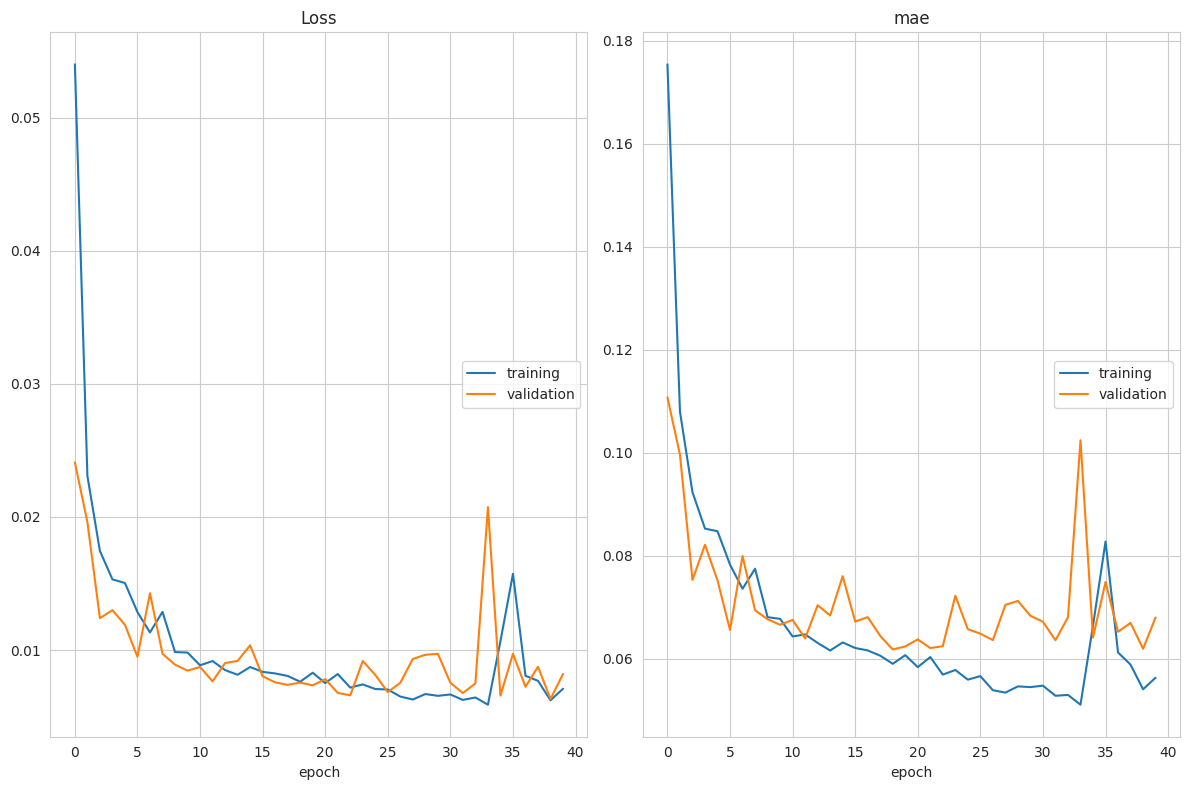

Loss
	training         	 (min:    0.006, max:    0.054, cur:    0.007)
	validation       	 (min:    0.006, max:    0.024, cur:    0.008)
mae
	training         	 (min:    0.051, max:    0.175, cur:    0.056)
	validation       	 (min:    0.062, max:    0.111, cur:    0.068)
363/363 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - loss: 0.0063 - mae: 0.0539 - val_loss: 0.0082 - val_mae: 0.0680

5️⃣  Performance Check...
----------------------------------------------------------------------
🏆 Final MAE: 4.5657 %
🏆 Final RMSE: 5.8712 %


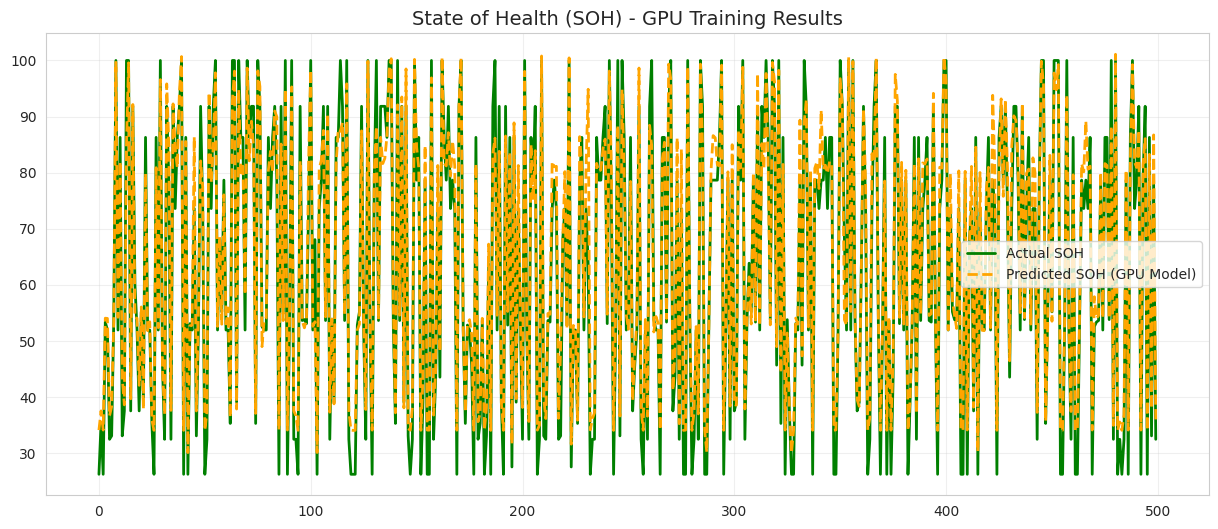


6️⃣  Exporting for IoT (Safe Weight Transfer)...
----------------------------------------------------------------------
✓ GPU Model weights saved.
   Building CPU-compatible clone for TFLite...
INFO:tensorflow:Assets written to: /tmp/tmp2j855g3_/assets


INFO:tensorflow:Assets written to: /tmp/tmp2j855g3_/assets


Saved artifact at '/tmp/tmp2j855g3_'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 100, 6), dtype=tf.float32, name='input_soh')
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  134969499775440: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134969499776592: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134969499775824: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134969499778704: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134969499775248: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134969499778512: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134969499778896: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134969499778320: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134969499776208: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134969494934288: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134969499773328: Tenso

W0000 00:00:1770278341.678993      55 tf_tfl_flatbuffer_helpers.cc:365] Ignored output_format.
W0000 00:00:1770278341.679048      55 tf_tfl_flatbuffer_helpers.cc:368] Ignored drop_control_dependency.
I0000 00:00:1770278341.700585      55 mlir_graph_optimization_pass.cc:425] MLIR V1 optimization pass is not enabled


In [4]:
# ========================================================================
# KAGGLE LSTM SOH (STATE OF HEALTH) TRAINING PIPELINE [GPU FAST + ROBUST]
# ========================================================================

# ========================================================================
# 1. SETUP & INSTALLATION
# ========================================================================
print("="*70)
print("INSTALLING DEPENDENCIES")
print("="*70)
!pip install livelossplot -q
print("\n✓ livelossplot installed successfully\n")

# ========================================================================
# IMPORTS
# ========================================================================
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from livelossplot import PlotLossesKeras
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import os
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

# Set styles
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (14, 6)

print("="*70)
print("❤️ SOH PREDICTION - GPU ACCELERATED ROBUST MODE")
print("="*70)
print(f"TensorFlow version: {tf.__version__}")
print("="*70 + "\n")

# ========================================================================
# 2. GPU CONFIGURATION (ENABLE CUDNN)
# ========================================================================
print("1️⃣  GPU Configuration...")
print("-" * 70)

gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print(f"✓ GPU DETECTED & ENABLED: {len(gpus)} device(s)")
        print("  🚀 CuDNN Acceleration: READY")
    except RuntimeError as e:
        print(f"⚠️ GPU error: {e}")
else:
    print("⚠️ No GPU detected. Training will be slow.")
print()

# ========================================================================
# 3. DATA LOADING & PREPARATION
# ========================================================================
print("2️⃣  Loading SOH Data...")
print("-" * 70)

csv_path = 'bms_soh_training_data.csv'
if not os.path.exists(csv_path):
    csv_path = 'processed_bms_data.csv' 

df = pd.read_csv(csv_path)
TARGET_VARIABLE = 'SOH'

feature_cols = [
    'Voltage_V', 'Current_A', 'Temperature_C', 
    'Internal_Resistance_Proxy', 'Cumulative_Energy_Wh', 'Thermal_Stress_Index'
]
available_features = [c for c in feature_cols if c in df.columns]

# Filter Data
df_clean = df.dropna(subset=available_features + [TARGET_VARIABLE]).reset_index(drop=True)
df_clean = df_clean[(df_clean[TARGET_VARIABLE] > 0) & (df_clean[TARGET_VARIABLE] <= 105)]

# Scaling
scaler_X = MinMaxScaler(feature_range=(0, 1))
scaler_y = MinMaxScaler(feature_range=(0, 1))

X_raw = df_clean[available_features].values
y_raw = df_clean[[TARGET_VARIABLE]].values

X_scaled = scaler_X.fit_transform(X_raw)
y_scaled = scaler_y.fit_transform(y_raw)

# Save Scalers
os.makedirs('scalers', exist_ok=True)
joblib.dump(scaler_X, 'scalers/scaler_X_soh.pkl')
joblib.dump(scaler_y, 'scalers/scaler_y_soh.pkl')

# Sequence Generation
def create_sequences(data_x, data_y, seq_length=100):
    xs, ys = [], []
    for i in range(0, len(data_x) - seq_length, 10): 
        xs.append(data_x[i:(i + seq_length)])
        ys.append(data_y[i + seq_length])
    return np.array(xs), np.array(ys)

SEQ_LENGTH = 100 
X_seq, y_seq = create_sequences(X_scaled, y_scaled, SEQ_LENGTH)

# Split
X_train, X_val, y_train, y_val = train_test_split(X_seq, y_seq, test_size=0.2, shuffle=True, random_state=42)

# TF Dataset (Batch 128 for Robustness)
BATCH_SIZE = 128
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train)).shuffle(5000).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val)).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

print(f"✓ Data Ready. Input Shape: {X_seq.shape}")

# ========================================================================
# 4. BUILD MODEL (GPU OPTIMIZED)
# ========================================================================
print("\n3️⃣  Building GPU-Optimized LSTM Model...")
print("-" * 70)

def build_soh_model(use_cudnn=True):
    keras.backend.clear_session()
    
    # If using CuDNN (GPU), we MUST set recurrent_dropout=0
    # If using CPU (for TFLite export), we use recurrent_dropout=0.01
    rec_drop = 0.0 if use_cudnn else 0.01 
    
    model = keras.Sequential([
        layers.Input(shape=(SEQ_LENGTH, len(available_features)), name='input_soh'),
        
        # LSTM 1
        layers.LSTM(64, return_sequences=True, name='lstm_soh_1', 
                   recurrent_dropout=rec_drop), 
        layers.Dropout(0.2),
        
        # LSTM 2
        layers.LSTM(32, return_sequences=False, name='lstm_soh_2', 
                   recurrent_dropout=rec_drop),
        layers.Dropout(0.2),
        
        layers.Dense(16, activation='relu', name='dense_features'),
        layers.Dense(1, activation='linear', name='output_soh')
    ], name='SOH_Predictor')
    
    return model

# Build the FAST model for training
model = build_soh_model(use_cudnn=True) 

model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss='mse', metrics=['mae'])
model.summary()
print("\n[INFO] CuDNN Enabled (recurrent_dropout=0). Training will be FAST.")

# ========================================================================
# 5. TRAIN
# ========================================================================
print("\n4️⃣  Training...")
print("-" * 70)

models_dir = 'models'
os.makedirs(models_dir, exist_ok=True)
checkpoint_path = os.path.join(models_dir, 'soh_model_gpu.keras')

callbacks = [
    PlotLossesKeras(),
    EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True),
    ModelCheckpoint(checkpoint_path, save_best_only=True, monitor='val_loss')
]

history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=40,
    callbacks=callbacks,
    verbose=1
)

# ========================================================================
# 6. VISUALIZATION
# ========================================================================
print("\n5️⃣  Performance Check...")
print("-" * 70)

y_pred_scaled = model.predict(X_val, verbose=0)
y_pred_percent = scaler_y.inverse_transform(y_pred_scaled)
y_true_percent = scaler_y.inverse_transform(y_val)

mae = np.mean(np.abs(y_pred_percent - y_true_percent))
rmse = np.sqrt(np.mean((y_pred_percent - y_true_percent) ** 2))

print(f"🏆 Final MAE: {mae:.4f} %")
print(f"🏆 Final RMSE: {rmse:.4f} %")

# Plot
n_view = min(500, len(y_true_percent))
plt.figure(figsize=(15, 6))
plt.plot(y_true_percent[:n_view], label='Actual SOH', color='green', linewidth=2)
plt.plot(y_pred_percent[:n_view], label='Predicted SOH (GPU Model)', color='orange', linestyle='--', linewidth=2)
plt.title(f'State of Health (SOH) - GPU Training Results', fontsize=14)
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# ========================================================================
# 7. SAFE TFLITE EXPORT (THE TRICK)
# ========================================================================
print("\n6️⃣  Exporting for IoT (Safe Weight Transfer)...")
print("-" * 70)

# 1. Save weights of the trained GPU model
weights_path = 'models/temp_weights.weights.h5'
model.save_weights(weights_path)
print("✓ GPU Model weights saved.")

# 2. Build a CPU-compatible clone (forces standard LSTM kernel)
print("   Building CPU-compatible clone for TFLite...")
with tf.device('/cpu:0'):
    cpu_model = build_soh_model(use_cudnn=False) # This sets recurrent_dropout=0.01
    
    # 3. Load the trained weights into the CPU model
    cpu_model.load_weights(weights_path)
    
    # 4. Convert the CPU model to TFLite
    converter = tf.lite.TFLiteConverter.from_keras_model(cpu_model)
    converter.target_spec.supported_ops = [
        tf.lite.OpsSet.TFLITE_BUILTINS, 
        tf.lite.OpsSet.SELECT_TF_OPS 
    ]
    converter._experimental_lower_tensor_list_ops = False
    
    tflite_model = converter.convert()
    
    tflite_path = 'models/soh_model_robust.tflite'
    with open(tflite_path, 'wb') as f:
        f.write(tflite_model)

print(f"✓ Saved TFLite Model: {tflite_path}")
print(f"✓ Saved Keras Model: {checkpoint_path}")
print("\n🎉 DONE. Fast Training + Working IoT Export.")